## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW,BertTokenizerFast,Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score

In [2]:
#matplotlib style to the standard style
plt.style.use('default')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read and clean data

In [4]:
training_data = pd.read_csv("/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv")

In [5]:
test = pd.read_csv("/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_testing_set.csv")
test.shape

(750, 4)

In [6]:
training_data.isnull().sum()

,0
Unnamed: 0,0
Tweet,9
Class,0


In [7]:
training_data.dropna(inplace=True)
training_data.isnull().sum()

,0
Unnamed: 0,0
Tweet,0
Class,0


In [8]:
train,val = train_test_split(training_data,test_size=0.15, random_state=42)

In [9]:
len(train), len(val)

(6367, 1124)

In [10]:
train['Class'].value_counts()

,count
Class,
neutral,2155
positive,2121
negative,2091


## Prepare Data and model

In [11]:
train['Class']=train['Class'].map({'negative': 0,'neutral': 1, 'positive': 2})
val['Class'] = val['Class'].map({'negative': 0,'neutral': 1, 'positive': 2})
test['Class'] = test['Class'].map({'negative': 0,'neutral': 1, 'positive': 2})

In [12]:
model = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabertv02', num_labels=len(train['Class'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabertv02')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Encode text & prepare dataloader

In [13]:
train_encodings = tokenizer(train['Tweet'].to_list(), truncation=True, padding=True, max_length=44)
val_encodings = tokenizer(val['Tweet'].to_list(), truncation=True, padding=True, max_length=44)
test_encodings = tokenizer(test["Tweet"].tolist(), truncation=True, padding=True,max_length=44)

In [14]:
train_labels = train['Class']
val_labels = val['Class']
test_labels = test['Class']

In [15]:
class SentimentDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx]).long()
      return item

  def __len__(self):
      return len(self.labels)

In [16]:
ds_train = SentimentDataset(train_encodings, train_labels)
ds_val =  SentimentDataset(val_encodings, val_labels)
ds_test =  SentimentDataset(test_encodings, test_labels)

### Training Arguments

In [17]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
  }

In [18]:
training_args = TrainingArguments(
    output_dir='/arabert-checkpoints',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    eval_strategy = "epoch",
    save_strategy = 'epoch',
    )
for param in model.parameters():
   param.data = param.data.contiguous()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics
)

## Training

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.775465,0.862100
2,No log,0.783014,0.858541
3,No log,0.827191,0.866548


TrainOutput(global_step=300, training_loss=0.02371159871419271, metrics={'train_runtime': 303.6517, 'train_samples_per_second': 62.904, 'train_steps_per_second': 0.988, 'total_flos': 431898619626936.0, 'train_loss': 0.02371159871419271, 'epoch': 3.0})

## Testing

In [ ]:
preds = trainer.predict(ds_test)

In [ ]:
y_pred = [np.argmax(i, axis=-1) for i  in preds.predictions]
y_test = ds_test.labels

In [ ]:
accuracy_score(y_test, y_pred)

0.712

              precision    recall  f1-score   support

    negative       0.90      0.57      0.70       250
     neutral       0.61      0.78      0.68       250
    positive       0.72      0.79      0.75       250

    accuracy                           0.71       750
   macro avg       0.74      0.71      0.71       750
weighted avg       0.74      0.71      0.71       750



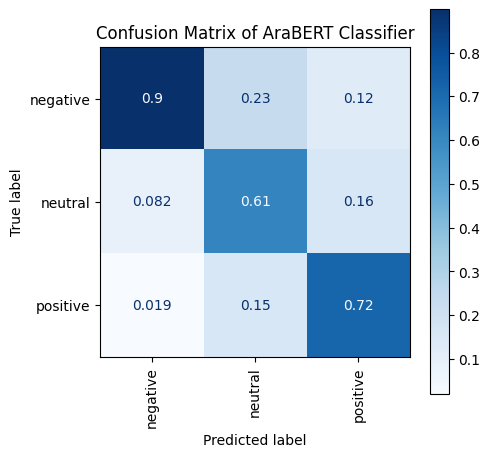

In [ ]:
model_name='AraBERT Classifier'
print(classification_report(y_test, y_pred,target_names=['negative','neutral','positive']))
fig,ax=plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=['negative','neutral','positive'],normalize='pred',cmap=plt.cm.Blues, xticks_rotation='vertical',ax=ax)
plt.title(f'Confusion Matrix of {model_name}')
plt.show()

### New

In [19]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.401745,0.838968
2,No log,0.404257,0.833630
3,No log,0.361035,0.870107


TrainOutput(global_step=300, training_loss=0.40386561075846356, metrics={'train_runtime': 270.1547, 'train_samples_per_second': 70.704, 'train_steps_per_second': 1.11, 'total_flos': 431898619626936.0, 'train_loss': 0.40386561075846356, 'epoch': 3.0})

In [21]:
preds = trainer.predict(ds_test)
y_pred = [np.argmax(i, axis=-1) for i  in preds.predictions]
y_test = ds_test.labels
accuracy_score(y_test, y_pred)

0.7413333333333333

              precision    recall  f1-score   support

    negative       0.90      0.63      0.74       250
     neutral       0.64      0.79      0.71       250
    positive       0.75      0.81      0.78       250

    accuracy                           0.74       750
   macro avg       0.76      0.74      0.74       750
weighted avg       0.76      0.74      0.74       750



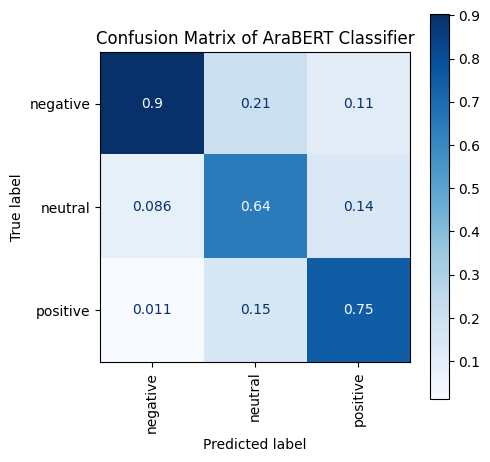

In [22]:
model_name='AraBERT Classifier'
print(classification_report(y_test, y_pred,target_names=['negative','neutral','positive']))
fig,ax=plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=['negative','neutral','positive'],normalize='pred',cmap=plt.cm.Blues, xticks_rotation='vertical',ax=ax)
plt.title(f'Confusion Matrix of {model_name}')
plt.show()

In [23]:
trainer.save_model("/content/drive/MyDrive/SeniorProject1/models/AraBERT-Classifier")